# AI21 Product Description Generator and rewriter

This notebook demonstrates a few key ideas for leveraging AI21 models. Specifically:

* Preprocessing of NLP data to detect where data original input data may itself be hallucinated or inaccurate.
* Leveraging zero-shot for rewriting descriptions and few shot learning for genrating product descriptions.

**NOTE:** If you are new to using LLMs try starting with [this](https://github.com/AI21Labs/ai21studio-devhub/blob/main/examples/Enhancing%20your%20online%20retail%20platform%20with%20generative%20AI.ipynb) introductory notebook, which gives a foundation for using AI21 Generative AI models.


### Install Prerequisites
If the notebook still fails even after updating the packages. Restart the kernel and execute the notebook again.

In [1]:
# Install the req. packages using the following command:
!pip install pip ai21 pyperclip -Uq nltk pandas
#verify package installation
!pip list | grep 'pandas\|matplotlib\|nltk\|numpy\|ai21\|pyperclip'
# import nltk and download stopwords
import nltk
nltk.download('stopwords')

ai21                                     2.1.1
ai21-tokenizer                           0.3.11
matplotlib                               3.8.2
matplotlib-inline                        0.1.6
nltk                                     3.8.1
numpy                                    1.26.4
pandas                                   2.2.1
pyperclip                                1.8.2


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/joshuabroyde/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import random
import numpy as np

import json
import os
os.environ["AI21_LOG_LEVEL"] = "DEBUG"

from ai21 import AI21Client
client = AI21Client()

# Set global random seed
random_seed = 42
random.seed(random_seed)
np.random.seed(random_seed)

examples_df = pd.read_csv('Product_Data_Examples.csv')
examples_df.head()

,Unnamed: 0,categ,title,description_column,attributes_column,num_attr,len_desc,len_attr
0,0,Micro and telephony/laptop/laptop/(not specifi...,"PC Ultra-Portable Acer Swift 5 SF514-55T 14"" I...",Acer Swift 5 SF514-55-74D3: sublimated lightne...,Memory cards reader: False || Product weight: ...,60,2598,2815
1,1,Micro and telephony/Laptop/MacBook/(not specif...,Apple MacBook Air 15.3 '' 256 GB SSD 16 GB Ram...,Immensely large. Infinitely fine.\nThe new 15 ...,Product weight: 1284.00 g || Screen features: ...,47,3905,3602
2,2,Micro and telephony/laptop/laptop/(not specifi...,"PC Portable HP 17-cn0416nf 17,3"" Intel Celeron...",A 17 -inch laptop with a great vision of the f...,Memory cards reader: False || Product weight: ...,56,4362,2809
3,3,Micro and telephony/laptop/laptop/(not specifi...,PC Portable Gaming Asus STRIX-G15-G513QR-HN050...,ASUS ROG Stix G15-G513QR-HHU050T: A victory ac...,Memory cards reader: False || Software provide...,61,3716,2978
4,4,Micro and telephony/Laptop/MacBook/(not specif...,APPLE MACBOOK PRO 13'''' TOUCH BAR 1 TO SSD 8 ...,MacBook Pro\nDeeply pro.\nWith the Apple M1 ch...,Memory cards reader: False || Product weight: ...,53,7464,3465


You can see from the first few rows above that, in addition to the category (`categ`) we have also unstructured `title` data and teh `attributres_column` which maps to structured (i.e. tabular data) from each product.

## Exploratory Data Analysis (EDA) to Detect Hallucinations
Prior to using AI21 Language models to build brand new descriptions, we will first explore whether the existing descriptions in the data are likely to contain hallucinations or otherwise inaccurate data.   

We do this by comparing the `Match rate` between the `attributes_column` and the `description_column`.  The `Match rate` is the number of unique words or numbers that appear in **both** the attributes and the description. The key idea is that new numbers or words that appear in the description are *more likely* to be hallucinations or errors. Consider the following simple example:

* Attributes: Inexpensive, Weight 13.2 ounces
* Description: The product is rated number 1 in the world; it is inexpensive and weights 13.2 ounces.

The first part of the description ("The product is rated number 1 in the world") is hallucinated; and in fact has no overlapping words with the attributes.

Note that the match-rate is merely a hueristic meant to detect patterns of hallucinatons. ; it will not work for synonyms or other complex 


We try to estimate how well the attributes match the description. we do so by:
1. Counting unique words appearences - does a word from the attr appears in the desc.
2. Count if numbers from the attributes appear in the desc and how much do they appear.



In [3]:
import string
import csv
from nltk.corpus import stopwords

# **get_words()**- creates a list of all words in a given text
# **percentage_distinct_words()** - checks match rate in 2 texts

count = 0
total = 0
def get_words(text:str, min_chars_in_word:int = 2)->list:
    """get words from a string

    Args:
        text (str): the string to break into words
        min_chars_in_word (int, optional): min word length in chars.. Defaults to 2.

    Returns:
        list: a list of words
    """
    final_stopwords_list = stopwords.words('english')
    return [word.strip(string.punctuation) for word in text.lower().split() if ((len(word) >= min_chars_in_word) and (word not in final_stopwords_list))]

def percentage_distinct_words(text1:str, text2:str, threshold = 0.2 ,numeric = False)->float:
    """check percentage of distinct words match rate in two texts

    Args:
        text1 (str): 1st string
        text2 (str): 2nd string
        numeric (bool, optional): are we checking numbers or words?. Defaults to False.

    Returns:
        float: percantage of match rate (1-0), 
               how many distinct words that appear in text2 appear in text1
    """
    words1 = set(get_words(text1))
    words2 = set(get_words(text2))
    
    if(numeric):
       words1 = {word for word in words1 if word.isnumeric()}
       words2 = {word for word in words2 if word.isnumeric()}
    
    if(len(words1) == 0):
            return 0
    
    res = len(words1.intersection(words2)) / len(words1)
    # if(res >= threshold):
        # print (f"Percentage of distinct words is above threshold {res}\n")
    return res

A histogram indicating the match rate distribution of the data will be printed.<br>
Make sure you understand these results (the more data you have closer to 1 the better the match rate).

In [4]:
examples_df.dropna(subset = ['description_column'])

,Unnamed: 0,categ,title,description_column,attributes_column,num_attr,len_desc,len_attr
0,0,Micro and telephony/laptop/laptop/(not specifi...,"PC Ultra-Portable Acer Swift 5 SF514-55T 14"" I...",Acer Swift 5 SF514-55-74D3: sublimated lightne...,Memory cards reader: False || Product weight: ...,60,2598,2815
1,1,Micro and telephony/Laptop/MacBook/(not specif...,Apple MacBook Air 15.3 '' 256 GB SSD 16 GB Ram...,Immensely large. Infinitely fine.\nThe new 15 ...,Product weight: 1284.00 g || Screen features: ...,47,3905,3602
2,2,Micro and telephony/laptop/laptop/(not specifi...,"PC Portable HP 17-cn0416nf 17,3"" Intel Celeron...",A 17 -inch laptop with a great vision of the f...,Memory cards reader: False || Product weight: ...,56,4362,2809
3,3,Micro and telephony/laptop/laptop/(not specifi...,PC Portable Gaming Asus STRIX-G15-G513QR-HN050...,ASUS ROG Stix G15-G513QR-HHU050T: A victory ac...,Memory cards reader: False || Software provide...,61,3716,2978
4,4,Micro and telephony/Laptop/MacBook/(not specif...,APPLE MACBOOK PRO 13'''' TOUCH BAR 1 TO SSD 8 ...,MacBook Pro\nDeeply pro.\nWith the Apple M1 ch...,Memory cards reader: False || Product weight: ...,53,7464,3465
...,...,...,...,...,...,...,...,...
92,92,Micro and telephony/mobile phone/smartphone/(n...,"Smartphone Xiaomi Mi 11 Lite 6.55 ""Double SIM ...","Stylish look, feel stylish\nSometimes a little...",Product weight: 157.00 g || Repairability inde...,29,1542,1483
93,93,Micro and telephony/mobile phone/smartphone/(n...,"Smartphone Xiaomi Redmi Note 11S 6.6 ""5g doubl...",Effective performance and a 5G connection with...,Product weight: 195.00 g || Maximum autonomy: ...,40,1890,1817
94,94,Micro and telephony/mobile phone/smartphone/,Smartphone Asus Zenfone 3 Max Plus ZC553KL-4G0...,"4G smartphone, GPS function, Android operating...",Product weight: 175.00 g || Touchscreen: True ...,38,209,1742
95,95,Micro and telephony/mobile phone/smartphone/(n...,"Samsung Galaxy A52 6.5 ""Sim Double SIM 128 GB ...",A bright and fluid infinity-o screen\nWith its...,Product weight: 189.00 g || Maximum autonomy: ...,33,3842,1887


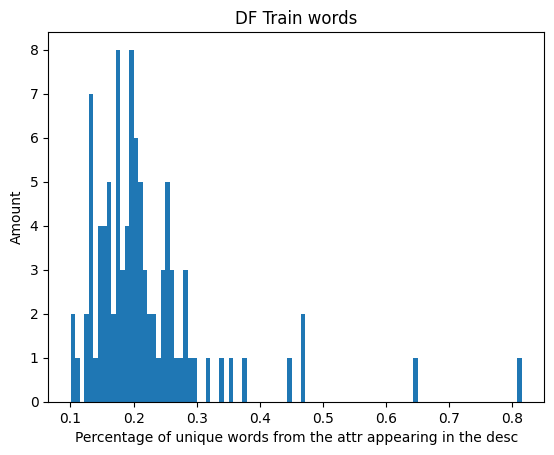

In [5]:
global count
global total

#NOTE - this is an example, change these df to fit your own data
df_clean = examples_df.dropna(subset = ['description_column'])
res      = examples_df.apply(lambda row: percentage_distinct_words(row['description_column'],
                                                                   row['attributes_column']), axis=1)

plt.hist(res, bins = 100)
plt.title("DF Train words")
plt.xlabel("Percentage of unique words from the attr appearing in the desc")
plt.ylabel("Amount")
plt.show()


You can see in the histogram above that most descriptions are somewhat related to attributes, but very few attributes have a high match rate. The median score is only 0.2.

In order to ensure that we are only using high quality date, we can choose to remove low threshold descriptions (i.e. descriptions that have a low match rate to the attributes).
For example, removing examples with low match rate because they might increase hallucinations<br>
You can see of course though that too much filtering may leading to discarding rich data; only 2 descriptions have a match rate above 0.5 and only 7 have a match rate above 0.3. Depending on the use case, different filtering may be needed.

In [6]:
# NOTE - change this to the relevant token len
token_len = 6

# NOTE - You must have these columns (len_desc, num_attr) in your data set - you can easily create them
# mean description len in tokens
mean_desc_len = examples_df["len_desc"].mean()
# median attr num
mean_attr_num = examples_df["num_attr"].mean()
# median description len in tokens
median_desc_len = examples_df["len_desc"].median()
# median attr num
median_attr_num = examples_df["num_attr"].median()

#ratios
num_attr_to_desc_len_median_ratio = median_desc_len/median_attr_num
num_attr_to_desc_len_mean_ratio = mean_desc_len/mean_attr_num

### 1.4 Test optimal attribute number to description length ration
This was created to try and see if we can optimize the <b><i>max_len</i></b> param

In this section we calculate what is the ratio between the number of attributes and the original description.<br>
The logic behind this is that the length of a description should not be many times greater than the number of attributes. Having an exceptionally long description with only few structured attributes is a symptom of hallucination. Consider the following Product example

Product Profile: {"Inexpensive","Useful"}
Product Description: This state-of-the-art kitchen product will revolutionize the way you cook! It's equipped with cutting-edge technology and features, making it the ultimate tool for any chef. With its sleek design and user-friendly controls, it's easy to use and clean. Plus, it's durable and built to last, so you can enjoy its many benefits for years to come. Don't settle for second best - upgrade to this sensational kitchen product today!

The overly long description is a symptom of hallucination. 


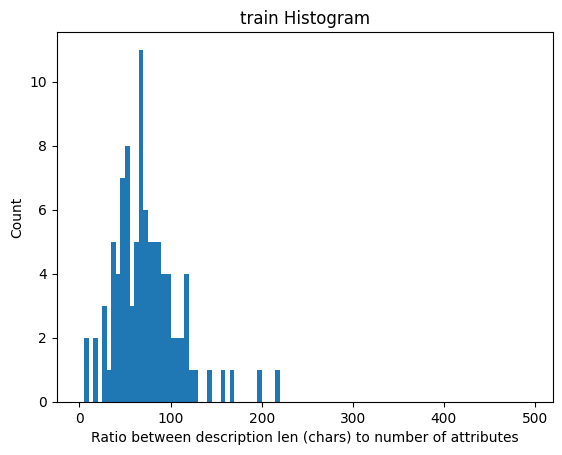

In [7]:
import numpy as np

def calc_desc_len_to_attr_num_ratio(desc_len_chars:int, attr_num:int)->float:
    """calculate the ratio between description length to number of attributes

    Args:
        desc_len_chars (int): number of chars in description
        attr_num (int): number of disticnt attributes

    Returns:
        float: the ratio
    """
    desc_len_chars_vec = np.array(desc_len_chars)
    attr_num_vec = np.array(attr_num)
    return np.divide(desc_len_chars_vec,attr_num_vec)
    
def plot_calc_desc_len_to_attr_num_ratio(desc_len_chars:int,
                                         attr_num, bins:int = 100,
                                         bin_size:int = 1,
                                         data_type_str:str = ""):
    """plot the ratio between description length to number of attributes

    Args:
        desc_len_chars (int): number of chars in description
        attr_num (_type_): number of disticnt attributes
        bins (int, optional): number of bins in hist. Defaults to 100.
        bin_size (int, optional): bin size. Defaults to 1.
        data_type_str (str, optional): hist title. Defaults to "".
    """
    desc_len_to_attr_num_ratio_vec = calc_desc_len_to_attr_num_ratio(desc_len_chars, attr_num)
    bins  = [x for x in range(0,bins*bin_size, bin_size)]
    plt.hist(desc_len_to_attr_num_ratio_vec, bins =bins) 
    plt.title(data_type_str+" Histogram") 
    plt.xlabel("Ratio between description len (chars) to number of attributes")
    plt.ylabel("Count")
    plt.show()

#NOTE: to use the commented code you need to create the columns :len_desc, num_attr 

# # for train data
plot_calc_desc_len_to_attr_num_ratio(examples_df["len_desc"], examples_df["num_attr"], 100, 5, "train")
#plot_calc_desc_len_to_attr_num_ratio(filtered_df_high_threshold["len_desc"], filtered_df_high_threshold["num_attr"], 100, 5, "train")
#plot_calc_desc_len_to_attr_num_ratio(filtered_df_low_threshold["len_desc"], filtered_df_low_threshold["num_attr"], 100, 5, "train")

# # for test data
# test_data = pd.read_csv('test.csv')
# plot_calc_desc_len_to_attr_num_ratio(test_data["len_desc"], test_data["num_attr"], 100, 5, "test")

We can see above that most descriptions have a characther length of between 50-75 ratio to the number of attributes. Only a few have very high ratios.

Next, we will procede with using AI21 Models on samples of the dataset.

## 2. Create prompt

### 2.1 Instructions
In the following sections, we will use a number of functions to preprocess the datasets in the pandas dataframe. These are provided as a convinience; and one could generate the prompt in other ways (e.g. Langchain templates etc.)

Create the instructions you will be using to generate the description. **Notice this is not the full prompt, only the final instruction.**

In [8]:
#
instruction_empty                    = "\n"
#NOTE: you can use and test different instructions - we reccomend doing so!!!
instruction_elaborated               = "\n\n" #YOU CAN ADD A MORE ELABORATED INSTRUCTION:
#NOTE: We'll discuss this when we get to the "Hybrid" prompt method
instruction_based_on_additional_data = "\n" #AN INSTRUCTION THAT SHOULD UTILIZE MORE THAN JUST THE ATTRIBUTES -> ADDITIONAL DATA:\n

### 2.2 Prompt creation functions
Here we define 2 ways of generating a prompt.
These 2 ways add 2 new columns to your DataFrame:<br>
1. Prompt - basically the prompt for a single product (can be used for 0 shot) including the instruction field (“create…:”).
2. Completion - the given description for this product (as this is train data you should have it, if you don’t ask for it).


#### 2.2.1 prompt with additional data
With additional data - will be used for the “Hybrid” method (defined later).

In [9]:
# Using description as additional data 
def prompt_with_additional_data(title, category, attributes, additional_data, instruction):
    res = f'''Title: {title}
Category: {category}
Attributes:\n* ''' + '\n* '.join([i.strip() for i in attributes.split('||')]) + f"""
\nAdditional information:\n{additional_data}\n{instruction}"""
    return res
    
def create_prompts_with_additional_data(df, instruction):
    df['prompt'] = df.apply(lambda row: prompt_with_additional_data(row.title, row.categ, row.attributes_column,
                                                                    row.description_column, instruction), axis=1)
    df['completion'] = df.description_column

#### 2.2.2 Prompt with no additional data
No additional data - will be used for the classic method (defined later).


In [10]:
# Using description as completion
def prompt_no_additional_data(title, category, attributes, instruction):
    res =  f"""Title: {title}
Category: {category}
Attributes:\n* """ + '\n* '.join([i.strip() for i in attributes.split('||')]) + f"\n{instruction}"
    return res
    
def create_prompts_no_additional_data(df, instruction):
    df['prompt']     = df.apply(lambda row: prompt_no_additional_data(row.title, row.categ, row.attributes_column, instruction),axis=1)
    df['completion'] = df.description_column 

## 3. Testing different description generation methods

### Define Key Functions

We define 3 key functions:
1. **call_ultra()** - which calls the model (notice it returns the end reason, we will use this for filtering later).
2. **generate_few_shots_prompt()** - generates a few shot prompt while:<br> 
    a. Calculating desired description length based on similar products.<br>
    b. Choosing similar products (from the same category) to generate a better prompt.
3. **create_desc_ultra_few_shots()** - generates a description for a product using a few shot prompt.


In [11]:
import random
import numpy as np
import ai21

#note, you must change the API key to match your own API key.

def call_ultra(prompt, num_results=1, max_tokens=2500):
    response = client.completion.create(
    model="j2-ultra",  # You can choose from various models like j2-light, j2-mid, j2-ultra
    prompt=prompt,
    max_tokens=300,
    temperature=0.7
    )

    #get the actual text from the response
    generated_text = response.completions[0].data.text
    return(generated_text)

def generate_few_shot_prompt(df,num_of_examaples, generate_sample_ind = None, token_len = 3):
    #make sure we set the desired product ind at the end 
    selected_samples_ind = random.sample(range(len(df)), num_of_examaples)
    if generate_sample_ind != None:
        if generate_sample_ind  in selected_samples_ind:
              selected_samples_ind.remove(generate_sample_ind)
              selected_samples_ind.append(generate_sample_ind)
        else:
            selected_samples_ind[-1] = generate_sample_ind
    
    few_shots         = [df.prompt[i]+df.completion[i] for i in selected_samples_ind[:-1]]
    char_len_desc     = [len(df.completion[i]) for i in selected_samples_ind[:-1]]
    avg_char_len_desc = round(np.average(char_len_desc) / token_len)
    #add extra len
    avg_char_len_desc += avg_char_len_desc * 0.2

    res = ""
    for i in range(len(few_shots)):
        res = res+few_shots[i]+"\n\n##\n\n"
    
    res = res+df.prompt[selected_samples_ind[-1]]
    chosen_sample_benchmark_completion = df.completion[selected_samples_ind[-1]]
    return res, chosen_sample_benchmark_completion, avg_char_len_desc

def create_desc_ultra_few_shots(df:pd.DataFrame, num_of_examaples:int ,instruction:str, generate_sample_ind:int = None):
    """generate a few shots product descriptions

    Args:
        df (pd.DataFrame): the DF to use for the few shot prompt
        num_of_examaples (int): how many example shoild the prompt include (the few in few shots = num of examples)
        instruction (str): instruction to use in prompt
        generate_sample_ind (int, optional): the index of the product we wnt to generate a description for. Defaults to None.

    Returns:
        (description,endReason), the prompt used, the benchmark completion
    """
    create_prompts_no_additional_data(df, instruction)
    few_shot_prompt, benchmark_completion, avg_char_len_desc = generate_few_shot_prompt(df, num_of_examaples, generate_sample_ind)
    return call_ultra(few_shot_prompt), few_shot_prompt, benchmark_completion

In [12]:
# Using description as completion
def prompt_no_additional_data(title, category, attributes, instruction):
    res =  f"""Title: {title}
Category: {category}
Attributes:\n* """ + '\n* '.join([i.strip() for i in attributes.split('||')]) + f"\n{instruction}"
    return res
    
def create_prompts_no_additional_data(df, instruction):
    df['prompt']     = df.apply(lambda row: prompt_no_additional_data(row.title, row.categ, row.attributes_column, instruction),axis=1)
    df['completion'] = df.description_column 



A few shot prompt utilizing title, attributes and original description as example completion.


In [13]:
# # Set up data; we will use only a small sample of the dataset.
eval_df  = pd.read_csv('Product_Data_Evaluation.csv')
examples_df = pd.read_csv('Product_Data_Examples.csv')
examples_df = examples_df.sample(4,random_state=42)
examples_df.reset_index(drop=True, inplace=True)

In [14]:
examples_df

,Unnamed: 0,categ,title,description_column,attributes_column,num_attr,len_desc,len_attr
0,62,Micro and telephony/mobile phone/smartphone/(n...,"Smartphone Asus Zenfone 10 5.9 ""5g Double nano...",Powerful in hand:\nThe small format that sees ...,Product weight: 172.00 g || Maximum autonomy: ...,45,5224,2174
1,40,Micro and telephony/laptop/laptop/(not specifi...,"PC Ultra-Portable Lenvo IdeaPad 5 14ALC05 14"" ...",Lenovo Ideapad 5 14alc05: refined for life\nTh...,Dedicated video memory: 16.00 GB || SSD disc c...,61,2497,2375
2,93,Micro and telephony/mobile phone/smartphone/(n...,"Smartphone Xiaomi Redmi Note 11S 6.6 ""5g doubl...",Effective performance and a 5G connection with...,Product weight: 195.00 g || Maximum autonomy: ...,40,1890,1817
3,18,Micro and telephony/laptop/laptop/(not specifi...,PC Portable Gaming Asus ROG Scar 18-G834JY-N60...,The formidable power\nSketch more images and w...,Memory cards reader: False || Product weight: ...,58,3930,2403


#### Generate Zero Shot Prompts

In [15]:
import random

def generate_zero_shot_prompt(df, instruction:str):
    """generate azero shot prompt

    Args:
        df (pandas.DataFrame): the samples data frame
        instruction (str): model instruction

    Returns:
        prompt - str: the zero shot prompt
        df.completion[sample_ind[0]] - str: the benchmark completion
    """
    create_prompts_no_additional_data(df, "")
    sample_ind = random.sample(range(len(df)), 1)
    prompt = df.prompt[sample_ind[0]]+f'\nAdditional information::\n{df.completion[sample_ind[0]]}\n{instruction}'
    return prompt, df.completion[sample_ind[0]]

### Generate Ultra Completions for Zero Shot prompts
In this example, we use a zero-shot approach for rewriting/condensing a description of a product. We pass to Ultra both the original product attributes, as well at the original product description.

In [16]:
prompt, benchmark_completion = generate_zero_shot_prompt(examples_df, instruction_based_on_additional_data)
completion = call_ultra(prompt)                                                     

print("___PROMPT___\n\n"+prompt+"\n\n")
print("\n___ULTRA COMPLETION___\n\n"+completion[0]+"\n\n")
print("\n___BENCHMARK COMPLETION___\n\n"+benchmark_completion)

___PROMPT___

Title: Smartphone Asus Zenfone 10 5.9 "5g Double nano Sim 256 GB Blue
Category: Micro and telephony/mobile phone/smartphone/(not specified data)
Attributes:
* Product weight: 172.00 g
* Maximum autonomy: NC
* Repairability index: 8.20 /10
* Additional characteristics: wireless recharge 15W; Audio: double stereo speakers, double microphone noise reduction, audio assistant Dirac equalizer; Dust resistance and water; Non -waterproof product, do not immerse
* Mobile Internet access: Yes, subject to network coverage.
* Voice recognition: yes
* Video resolution: 8k@24 FPS, 4K@30/60/120 FPS, 1080p@30/60/240 FPS, Selfie video - 4K@30fps, 1080p@30/60fps
* Extension port: no
* Camera: Rear camera: wide angle: 50MP Sony IMX766 F/1.9, ultra wide angle: 13MP 120 °; Front camera: Self portrait: 32MP RGBW technology
* Processor: Qualcomm® Snapdragon ™ 8 Gen 2, Octa-Core (1x3.2 GHz Cortex-X3 & 2x2.8 GHz Cortex-A715 & 2x2.8 GHz Cortex-A710 & 3x2.0 GHz Cortex-A510)
* DAS DAS head in W/KG: 

### Few Shot creation of a New Description
In this example, we use a few shot approach to create a brand new description of a product. For the few shot examples, we pass to the model the product attributes, as well as the human generated descriptions. We then pass just the attributes of the product we want Ultra to create a new description for.

In [17]:
# Set up data
#examples_df = pd.read_csv('Product_Data_Examples.csv')
create_prompts_no_additional_data(examples_df, instruction_empty)


In [18]:
completion, prompt, benchmark_completion = create_desc_ultra_few_shots(examples_df,
                                                                       3,
                                                                       instruction = instruction_elaborated)
print("___PROMPT___\n\n"+prompt+"\n\n")
print("\n___ULTRA COMPLETION___\n\n"+completion[0]+"\n\n")
print("\n___BENCHMARK COMPLETION___\n\n"+benchmark_completion)


___PROMPT___

Title: Smartphone Asus Zenfone 10 5.9 "5g Double nano Sim 256 GB Blue
Category: Micro and telephony/mobile phone/smartphone/(not specified data)
Attributes:
* Product weight: 172.00 g
* Maximum autonomy: NC
* Repairability index: 8.20 /10
* Additional characteristics: wireless recharge 15W; Audio: double stereo speakers, double microphone noise reduction, audio assistant Dirac equalizer; Dust resistance and water; Non -waterproof product, do not immerse
* Mobile Internet access: Yes, subject to network coverage.
* Voice recognition: yes
* Video resolution: 8k@24 FPS, 4K@30/60/120 FPS, 1080p@30/60/240 FPS, Selfie video - 4K@30fps, 1080p@30/60fps
* Extension port: no
* Camera: Rear camera: wide angle: 50MP Sony IMX766 F/1.9, ultra wide angle: 13MP 120 °; Front camera: Self portrait: 32MP RGBW technology
* Processor: Qualcomm® Snapdragon ™ 8 Gen 2, Octa-Core (1x3.2 GHz Cortex-X3 & 2x2.8 GHz Cortex-A715 & 2x2.8 GHz Cortex-A710 & 3x2.0 GHz Cortex-A510)
* DAS DAS head in W/KG: 

### Conclusion
We have demonstrated in this notebook key ideas for 1. preprocessing NLP data and 2. demonstrating why Few Shot learning examples are essential for generating rich descriptions. Feel free to continue exploring further prompt engineering techniques in the context of this dataset. For example, this notebook does not use the "Additional Data" component of the products, which can create even richer descriptions.